In [20]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

In [21]:
#getting the dataset 
data = pd.read_csv("soil_health_monitoring_system.csv")
data=data.drop(['State','City','Weather Condition'],axis=1)


In [22]:
data.head()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Sample ID                   150 non-null    int64  
 1   Organic Matter (%)          150 non-null    float64
 2   Nitrogen (ppm)              150 non-null    int64  
 3   Phosphorus (ppm)            150 non-null    int64  
 4   Potassium (ppm)             150 non-null    int64  
 5   pH Level                    150 non-null    float64
 6   Microbial Activity (CFU/g)  150 non-null    float64
 7   Soil Structure (1-5)        150 non-null    int64  
 8   Moisture Retention (%)      150 non-null    float64
 9   Iron (ppm)                  150 non-null    float64
 10  Zinc (ppm)                  150 non-null    float64
 11  Temperature (°C)            150 non-null    int64  
 12  Soil Salinity (dS/m)        150 non-null    float64
 13  Soil Compaction (g/cm³)     150 non

In [23]:
# Convert to DataFrame
df = pd.DataFrame(data)
label_encoder = LabelEncoder()
df['Soil Health'] = label_encoder.fit_transform(df['Soil Health'])
df.head()

,Sample ID,Organic Matter (%),Nitrogen (ppm),Phosphorus (ppm),Potassium (ppm),pH Level,Microbial Activity (CFU/g),Soil Structure (1-5),Moisture Retention (%),Iron (ppm),Zinc (ppm),Temperature (°C),Soil Salinity (dS/m),Soil Compaction (g/cm³),Soil Health
0,1,2.6,39,29,241,7.3,886911.1,3,19.4,8.4,1.4,29,0.46,1.22,1
1,2,2.0,35,15,195,6.7,1384623.2,2,14.1,8.2,1.2,25,0.44,1.13,1
2,3,4.8,23,17,202,6.9,1230697.0,2,14.7,7.5,1.0,29,0.27,1.13,0
3,4,3.4,28,22,271,6.4,908546.2,3,14.6,8.2,0.8,29,0.31,1.10,1
4,5,2.1,28,29,256,6.3,903060.4,2,23.8,8.2,1.0,28,0.48,1.25,1


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
# from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore')

In [25]:
# 2 datasets
D = data[(data['Soil Health'] != 0)]
H = data[(data['Soil Health'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['Soil Health'].value_counts().values.tolist(), 
                    y = ['healthy','UnHealthy' ], 
                    orientation = 'h', 
                    text=data['Soil Health'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','Unhealthy'], values = data['Soil Health'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [26]:
target_count()
target_percent()


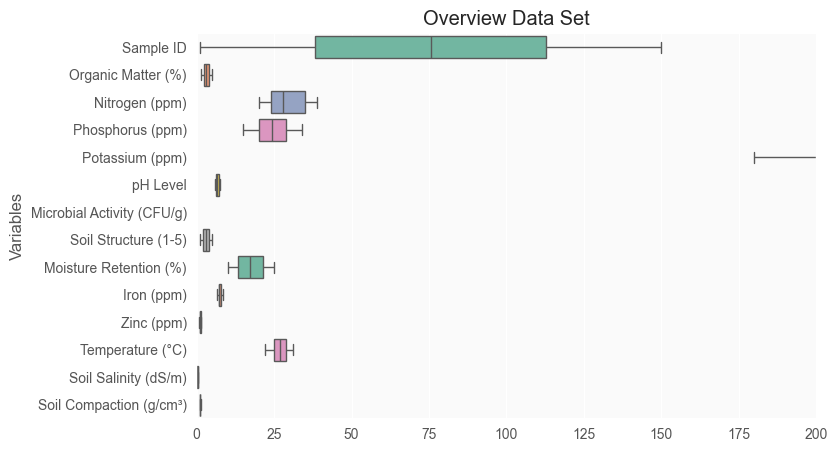

In [55]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(8, 5))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

In [48]:
def correlation_plot():
    #correlation
    correlation = df.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            autosize = False,
                            height  = 500,
                            width   = 700,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 10)),
                            xaxis   = dict(tickfont = dict(size = 10)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

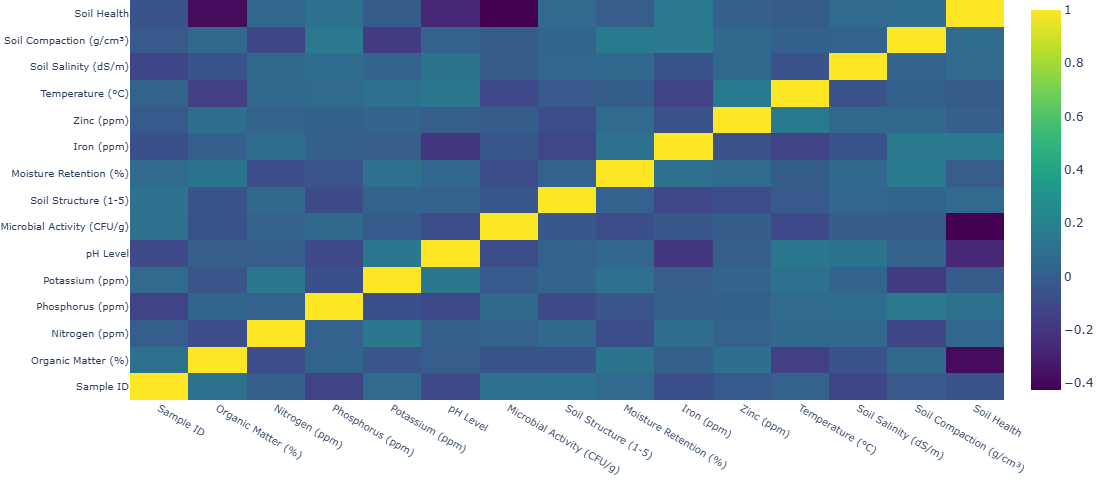

In [49]:
correlation_plot()

In [30]:
# Features and Labels
X = df.drop(columns=['Soil Health'])
y = df['Soil Health']

X.head()

,Sample ID,Organic Matter (%),Nitrogen (ppm),Phosphorus (ppm),Potassium (ppm),pH Level,Microbial Activity (CFU/g),Soil Structure (1-5),Moisture Retention (%),Iron (ppm),Zinc (ppm),Temperature (°C),Soil Salinity (dS/m),Soil Compaction (g/cm³)
0,1,2.6,39,29,241,7.3,886911.1,3,19.4,8.4,1.4,29,0.46,1.22
1,2,2.0,35,15,195,6.7,1384623.2,2,14.1,8.2,1.2,25,0.44,1.13
2,3,4.8,23,17,202,6.9,1230697.0,2,14.7,7.5,1.0,29,0.27,1.13
3,4,3.4,28,22,271,6.4,908546.2,3,14.6,8.2,0.8,29,0.31,1.10
4,5,2.1,28,29,256,6.3,903060.4,2,23.8,8.2,1.0,28,0.48,1.25


In [31]:
y.head()

0    1
1    1
2    0
3    1
4    1
Name: Soil Health, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 83, number of negative: 22
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.790476 -> initscore=1.327798
[LightGBM] [Info] Start training from score 1.327798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

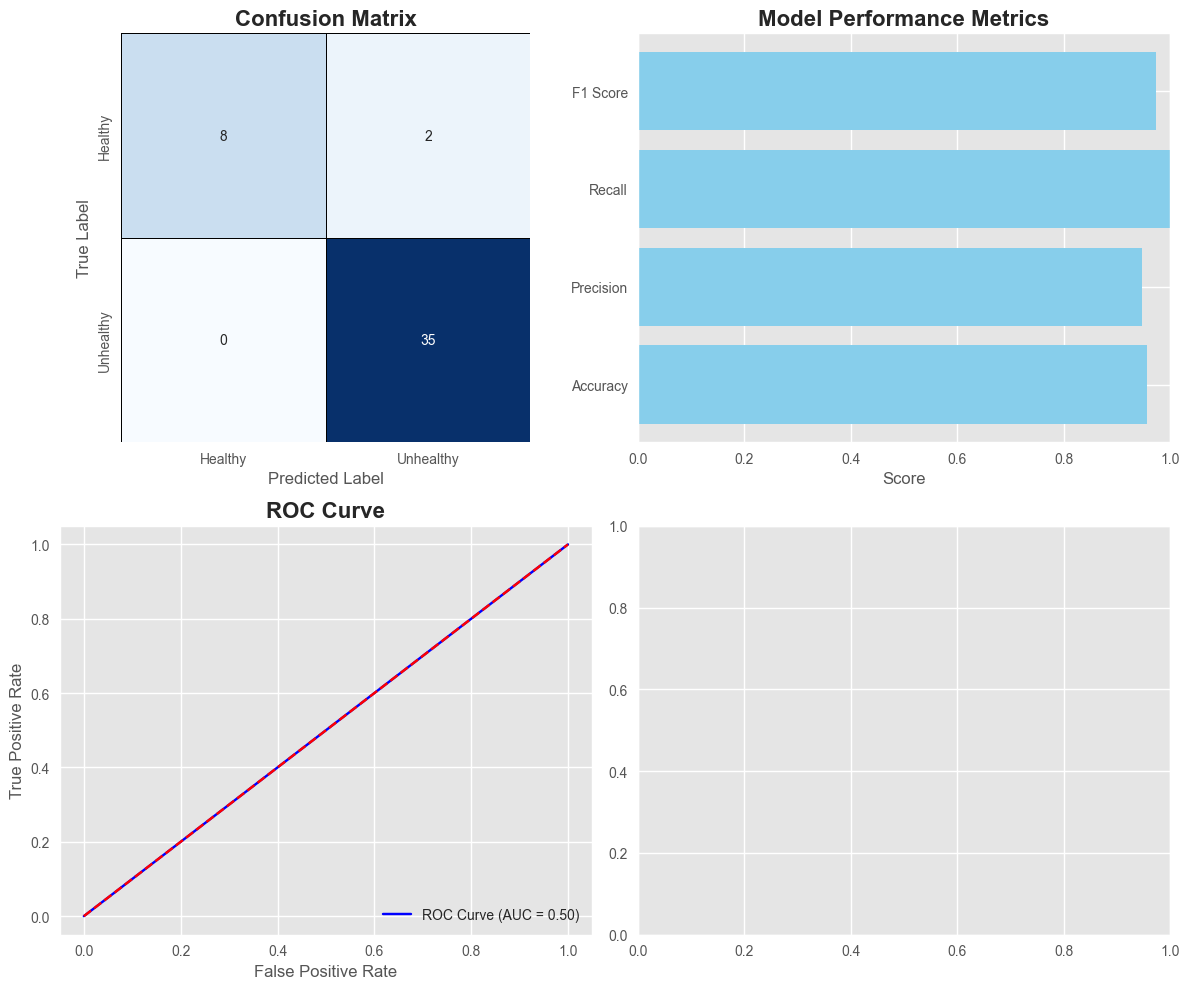


Feature Importance:
                        Feature  Importance
6   Microbial Activity (CFU/g)          48
1           Organic Matter (%)          40
5                     pH Level          39
2               Nitrogen (ppm)          13
4              Potassium (ppm)          12
13     Soil Compaction (g/cm³)          11
0                    Sample ID          10
3             Phosphorus (ppm)           4
9                   Iron (ppm)           4
8       Moisture Retention (%)           4
11            Temperature (°C)           4
12        Soil Salinity (dS/m)           2
7         Soil Structure (1-5)           0
10                  Zinc (ppm)           0


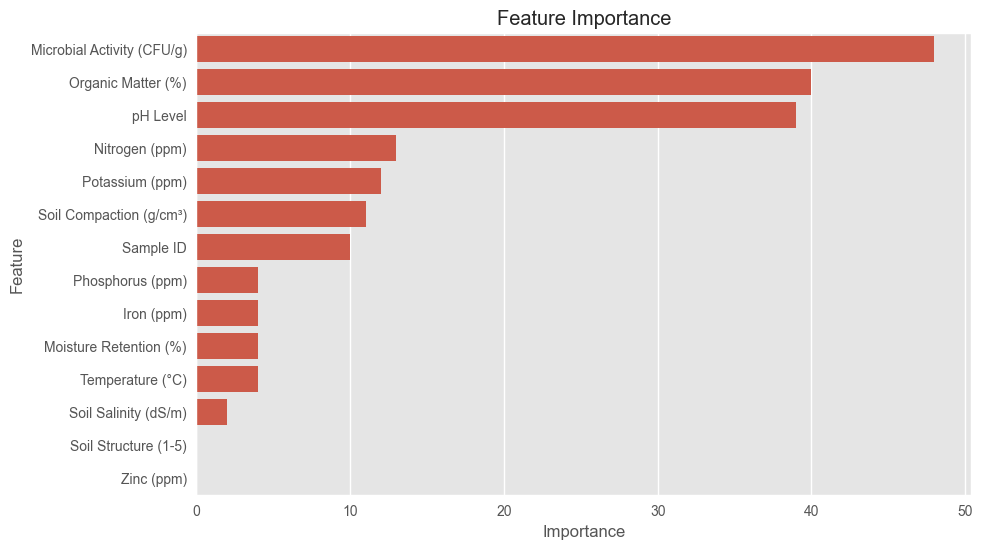

In [66]:

from sklearn.metrics import f1_score
# LightGBM Model
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)

# Hyperparameters to tune
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 50),
    'min_child_samples': randint(10, 50),
    'min_child_weight': uniform(0.001, 0.1),
    'subsample': uniform(0.5, 1.0),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.5, 1.0),
    'reg_alpha': uniform(0.0, 1.0),
    'reg_lambda': uniform(0.0, 1.0)
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Predicting on test data
y_pred = random_search.predict(X_test_scaled)
y_probs = random_search.predict_proba(X_test)[:, 1]

# Model Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)
class_names=['Healthy','Unhealthy'];

# Display Performance
print("Model Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)



#starting plot



# # Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# # Create a figure with subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# fig.suptitle('Model Performance Metrics', fontsize=16)

# # Plot Confusion Matrix
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             linewidths=0.5, linecolor='black', ax=axs[0, 0])
# axs[0, 0].set_title('Confusion Matrix', fontsize=14)
# axs[0, 0].set_xlabel('Predicted Label', fontsize=12)
# axs[0, 0].set_ylabel('True Label', fontsize=12)

# # Plot ROC Curve
# axs[0, 1].plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc))
# axs[0, 1].plot([0, 1], [0, 1], color='red', linestyle='--')
# axs[0, 1].set_xlim([0.0, 1.0])
# axs[0, 1].set_ylim([0.0, 1.05])
# axs[0, 1].set_title('Receiver Operating Characteristic', fontsize=14)
# axs[0, 1].set_xlabel('False Positive Rate', fontsize=12)
# axs[0, 1].set_ylabel('True Positive Rate', fontsize=12)
# axs[0, 1].legend(loc='lower right')

# # Display Accuracy and Precision
# axs[1, 0].bar(['Accuracy', 'Precision'], [accuracy, precision], color=['green', 'orange'])
# axs[1, 0].set_ylim([0, 1])
# axs[1, 0].set_title('Model Accuracy and Precision', fontsize=14)
# axs[1, 0].set_ylabel('Score', fontsize=12)

# # Hide the last subplot as we're only using three plots
# axs[1, 1].axis('off')

# # Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
# plt.show()


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            linewidths=0.5, linecolor='black', ax=axs[0, 0], square=True)
axs[0, 0].set_title('Confusion Matrix', fontsize=16, fontweight='bold')
axs[0, 0].set_xlabel('Predicted Label', fontsize=12)
axs[0, 0].set_ylabel('True Label', fontsize=12)
axs[0, 0].set_xticklabels(class_names)
axs[0, 0].set_yticklabels(class_names)

# 2. Performance Metrics
metrics = [accuracy, precision, recall, f1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
axs[0, 1].barh(metrics_names, metrics, color='skyblue')
axs[0, 1].set_title('Model Performance Metrics', fontsize=16, fontweight='bold')
axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_xlabel('Score', fontsize=12)

# 3. ROC Curve
axs[1, 0].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
axs[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[1, 0].set_title('ROC Curve', fontsize=16, fontweight='bold')
axs[1, 0].set_xlabel('False Positive Rate', fontsize=12)
axs[1, 0].set_ylabel('True Positive Rate', fontsize=12)
axs[1, 0].legend(loc='lower right')

# 4. Adjust layout
plt.tight_layout()
plt.show()




#ending plot 


# Score Tables
importance = random_search.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance_df)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()



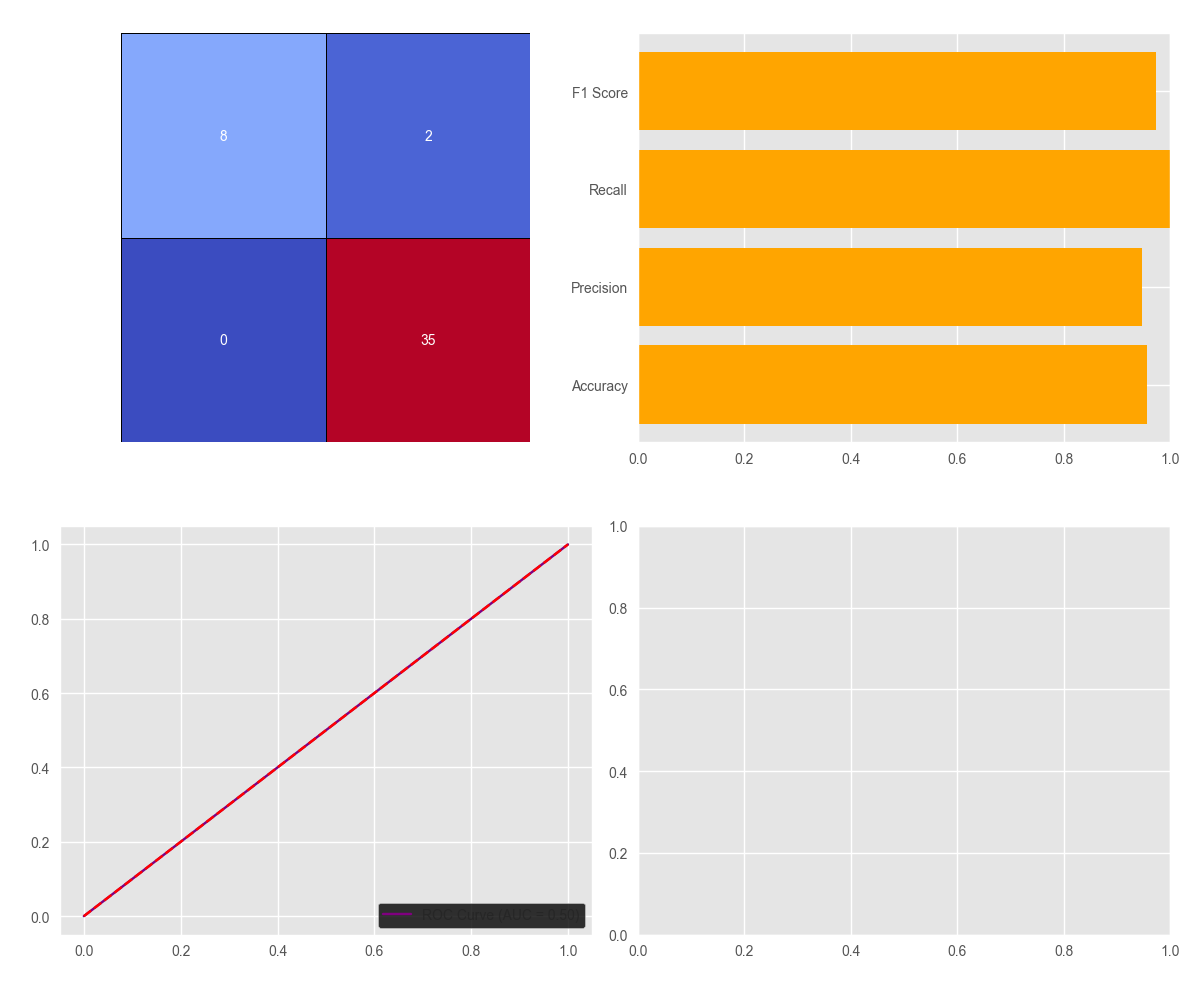


Feature Importance:
                        Feature  Importance
6   Microbial Activity (CFU/g)          48
1           Organic Matter (%)          40
5                     pH Level          39
2               Nitrogen (ppm)          13
4              Potassium (ppm)          12
13     Soil Compaction (g/cm³)          11
0                    Sample ID          10
3             Phosphorus (ppm)           4
9                   Iron (ppm)           4
8       Moisture Retention (%)           4
11            Temperature (°C)           4
12        Soil Salinity (dS/m)           2
7         Soil Structure (1-5)           0
10                  Zinc (ppm)           0


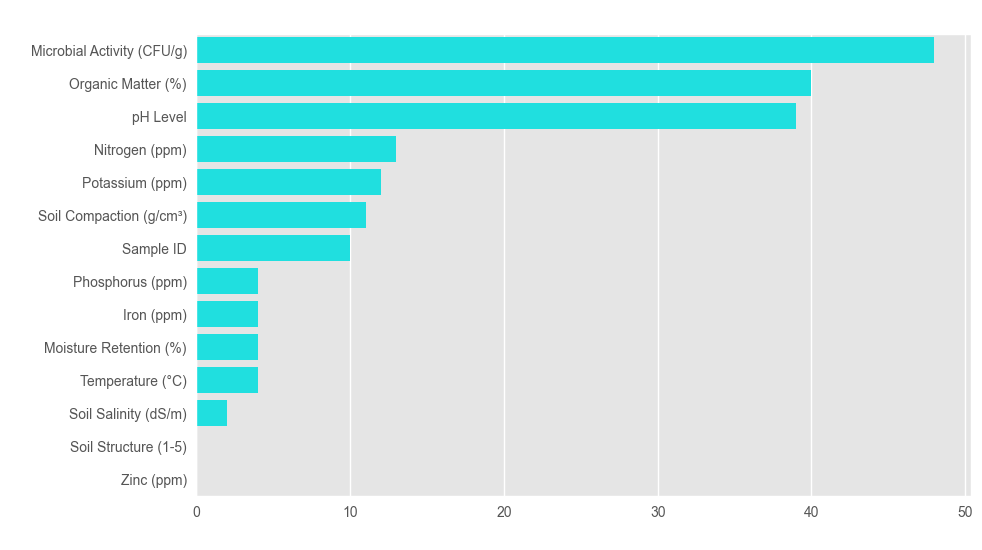

In [71]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            linewidths=0.5, linecolor='black', ax=axs[0, 0], square=True)
axs[0, 0].set_title('Confusion Matrix', fontsize=16, fontweight='bold', color='white')
axs[0, 0].set_xlabel('Predicted Label', fontsize=12, color='white')
axs[0, 0].set_ylabel('True Label', fontsize=12, color='white')
axs[0, 0].set_xticklabels(class_names, color='white')
axs[0, 0].set_yticklabels(class_names, color='white')

# 2. Performance Metrics
metrics = [accuracy, precision, recall, f1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
axs[0, 1].barh(metrics_names, metrics, color='orange')  # Changed to a bright color
axs[0, 1].set_title('Model Performance Metrics', fontsize=16, fontweight='bold', color='white')
axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_xlabel('Score', fontsize=12, color='white')

# 3. ROC Curve
axs[1, 0].plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')  # Changed to a bright color
axs[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[1, 0].set_title('ROC Curve', fontsize=16, fontweight='bold', color='white')
axs[1, 0].set_xlabel('False Positive Rate', fontsize=12, color='white')
axs[1, 0].set_ylabel('True Positive Rate', fontsize=12, color='white')
axs[1, 0].legend(loc='lower right', facecolor='black', fontsize=10, frameon=True)

# 4. Adjust layout
plt.tight_layout()
plt.show()

# Ending plot 

# Score Tables
importance = random_search.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance_df)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='cyan')  # Changed to a bright color
plt.title('Feature Importance', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Importance', fontsize=12, color='white')
plt.ylabel('Feature', fontsize=12, color='white')
plt.show()


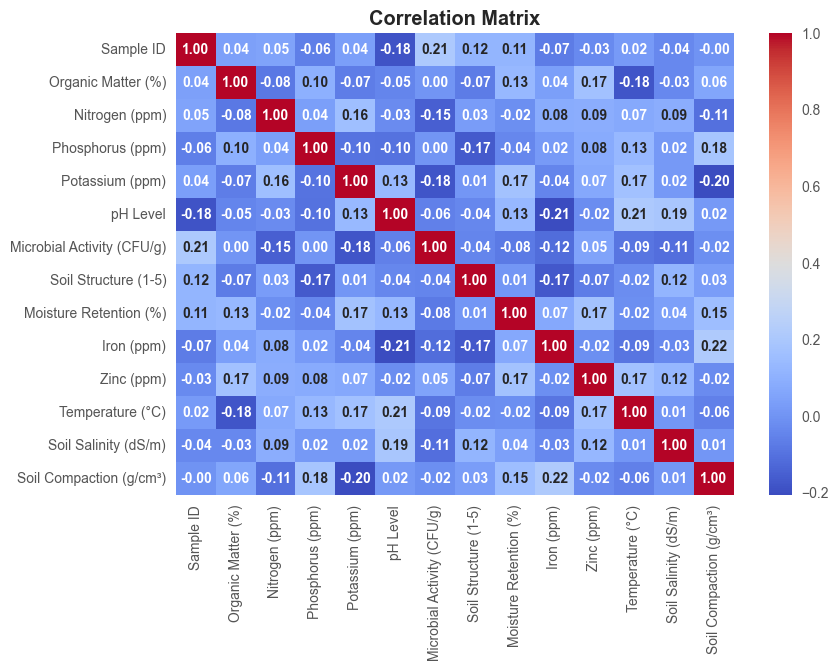

In [73]:
plt.figure(figsize=(9, 6))
corr_matrix = pd.DataFrame(X_train_scaled, columns=X.columns).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={'weight': 'bold'})
plt.title('Correlation Matrix',fontweight='bold')
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 105, number of negative: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 135, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.777778 -> initscore=1.252763
[LightGBM] [Info] Start training from score 1.252763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

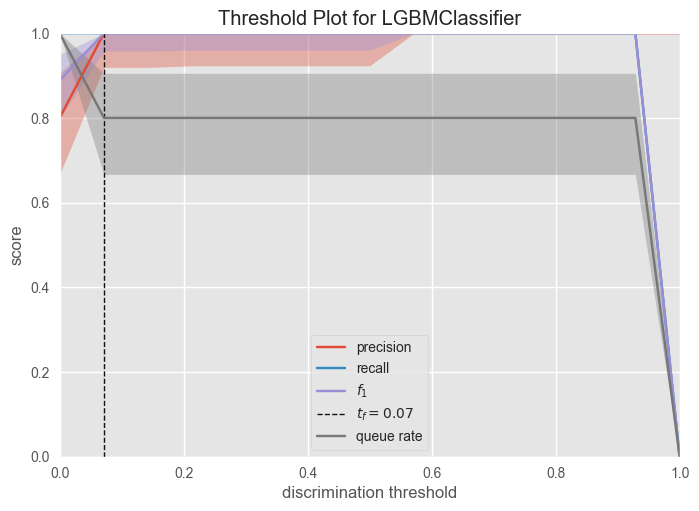

<Axes: title={'center': 'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [35]:

# Instantiate the visualizer
visualizer = DiscriminationThreshold(lgb_model)

# Fit the model and visualize the discrimination threshold
visualizer.fit(X, y)  
visualizer.show() 

In [36]:

# K-Nearest Neighbors (KNN) Model
knn_model = KNeighborsClassifier()

# Hyperparameters to tune for KNN
param_dist_knn = {
    'n_neighbors': randint(1, 30),
    'weights': ['uniform', 'distance'],
    'leaf_size': randint(10, 50),
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# RandomizedSearchCV for KNN hyperparameter tuning
random_search_knn = RandomizedSearchCV(estimator=knn_model, param_distributions=param_dist_knn,
                                       n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit the model for KNN
random_search_knn.fit(X_train, y_train)

# Best hyperparameters for KNN
print("\nBest Hyperparameters for KNN:", random_search_knn.best_params_)

# Predicting on test data for KNN
y_pred_knn = random_search_knn.predict(X_test)

# Model Performance Metrics for KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)

# Display KNN Performance
print("\nKNN Model Accuracy: {:.2f}%".format(accuracy_knn * 100))
print("\nKNN Confusion Matrix:\n", conf_matrix_knn)
print("\nKNN Classification Report:\n", class_report_knn)


Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Hyperparameters for KNN: {'leaf_size': 17, 'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}

KNN Model Accuracy: 77.78%

KNN Confusion Matrix:
 [[ 0 10]
 [ 0 35]]

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.78      1.00      0.88        35

    accuracy                           0.78        45
   macro avg       0.39      0.50      0.44        45
weighted avg       0.60      0.78      0.68        45



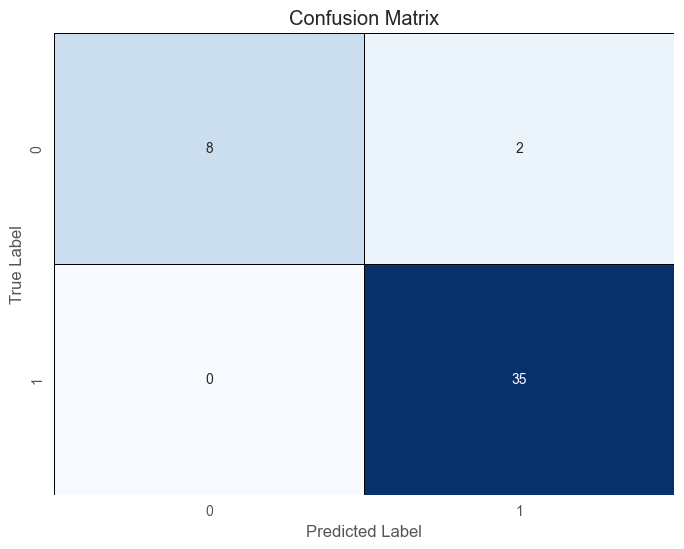

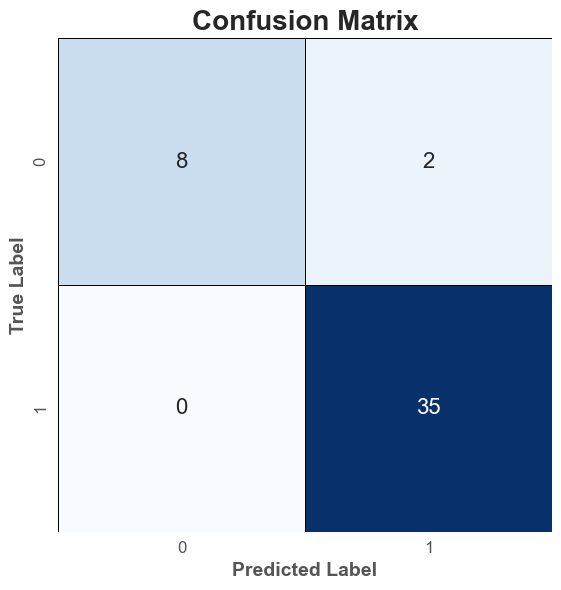